<a href="https://colab.research.google.com/github/KSwaviman/Social-Dynamics-Project/blob/main/Social_Dynamics_Lab_Project_l_229220.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Impact of Context and Personality on Student Mood: A machine Learning Approach


![](https://drive.google.com/uc?export=view&id=1YIW6kzijo6TQkDtAp2nN3XtDI6jMnkiu)

Kumar Swaviman </br>
swaviman.kumar@studenti.unitn.it</br>
Masters in Data Science</br>
Department of Sociology & Social Research
Università degli Studi di Trento </br>

---

</br>


***Abstract*** - This study aims at understanding the relation between various factors and a
student's mood and how their personality traits affect this relation.Data used for this study
was collected through a smartphone app called i-Log, using questionnaires as well as
smartphone sensors. A GPS sensor was used in this case. Data was collected over a month
period The datasets were cleaned, pre-processed and merged together to form a master
dataset. Statistical tests were performed to check if there exists any difference between the
mood over weekdays and over weekends and also between students of various personalities.
Machine Learning methods such as Random Forest and Gradient Boosting were used to
predict mood. Results showed that the most contributing predictors were varying based on
personalities of the students and the time of the week. These findings provide insights into
how contextual factors, sensor data and personality differences interact to shape a
student's mood.

# 1. Importing necessary libraries:

In [2]:
# importing Libraries and Sensor Data

import pandas as pd
import numpy as np
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 2. Data Cleaning & Preprocessing

Under this section i have performed some datacleaning and pre-processing operation. </br> Also i have done inner joins and left joins in order to merge all 3 datasets into one final dataset. </br></br>
Please note that the final merged dataframe is exported and re-imported to save time in reproducing the code. While building this code, due to the large size of the datasets, session used to crash quite often resulting in data loss. To avoid this such measure has been taken. </br></br>
**I recommend you to jump directly to Section 2.4 and execute the cells thereafter.**


## 2.1 Preparing GPS Data:

The original dataset is hosted in G Drive to make the code reproducible without needng any dependencies. Executing the cell will fetch & load the data automatically. 

In [7]:
# Hosted the original dataset in G Drive to make the code reproducible without any dependencies

# sensordf = pd.read_csv("/content/drive/MyDrive/Hosted_Datasets/Sensordf.csv")  # uncomment and execute if offline

sensordf = pd.read_csv("https://drive.google.com/uc?export=download&id=1WU8CIBgR1mK5zJGga_SJRhAuIhrAaIsC")

Extracting Date, time and hour from the timestamp column. Since timestamp is in string, it needs to be split in order to separate out the date and time parts.

In [ ]:
# add time column

def insert_space(string, integer):
    return string[0:integer] + ' ' + string[integer:]
    insert_space(df['date'], 9)

sensordf['Time'] = sensordf['timestamp'].str.slice(8, 12)
sensordf['Date'] = sensordf['timestamp'].str.slice(0, 8)

sensordf['Date'] = sensordf['Date'].apply(lambda x: insert_space(x, 4))
sensordf['Date'] = sensordf['Date'].apply(lambda x: insert_space(x, 7))

sensordf['Time'] = sensordf['Time'].apply(lambda x: insert_space(x, 2))

sensordf['hour'] = sensordf['Time'].str.slice(0, 2)

sensordf['Date'] = sensordf['Date'].str.replace(" ", "/")
sensordf['Time'] = sensordf['Time'].str.replace(" ", ":")

sensordf[["timestamp","Date","Time","hour"]].head(2)

,timestamp,Date,Time,hour
0,20201112151200000000,2020/11/12,15:12,15
1,20201112154200000000,2020/11/12,15:42,15


Let's check if the sensor data has any missing values.

In [ ]:
sensordf.isna().sum()

Unnamed: 0          0
timestamp           0
userid              0
suburb         658985
city                0
region              0
moving              0
fclass0        890016
fclass1       1277262
fclass2       1554318
fclass3       1680341
fclass4       1725309
fclass5       1756151
fclass6       1807975
fclass7       1847326
fclass8       1873809
fclass9       1882959
fclass10      1891522
fclass11      1896329
fclass12      1900007
fclass13      1903980
fclass14      1906362
fclass15      1914523
fclass16      1916532
fclass17      1917639
fclass18      1918283
fclass19      1918651
Time                0
Date                0
hour                0
dtype: int64

Some features have a lot of missing values. 

In [ ]:
# and the total row count is:

sensordf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919933 entries, 0 to 1919932
Data columns (total 30 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   timestamp   object
 2   userid      int64 
 3   suburb      object
 4   city        object
 5   region      object
 6   moving      bool  
 7   fclass0     object
 8   fclass1     object
 9   fclass2     object
 10  fclass3     object
 11  fclass4     object
 12  fclass5     object
 13  fclass6     object
 14  fclass7     object
 15  fclass8     object
 16  fclass9     object
 17  fclass10    object
 18  fclass11    object
 19  fclass12    object
 20  fclass13    object
 21  fclass14    object
 22  fclass15    object
 23  fclass16    object
 24  fclass17    object
 25  fclass18    object
 26  fclass19    object
 27  Time        object
 28  Date        object
 29  hour        object
dtypes: bool(1), int64(2), object(27)
memory usage: 426.6+ MB


From info and isna method we understand that a few features have almost 99% 
missing values. We need to take care of this sparisity.

In [ ]:
# this many missing value in one particular col
191828300/1919932

99.91411154145042

Checking entries in fclass19 column to understand the data.

In [ ]:
pd.set_option('max_columns', None)
sensordf.loc[sensordf['fclass19'].notnull()].head(2)

,Unnamed: 0,timestamp,userid,suburb,city,region,moving,fclass0,fclass1,fclass2,fclass3,fclass4,fclass5,fclass6,fclass7,fclass8,fclass9,fclass10,fclass11,fclass12,fclass13,fclass14,fclass15,fclass16,fclass17,fclass18,fclass19,Time,Date,hour
27193,27193,20201127111600000000,2,Centro storico Trento,Territorio Val d'Adige,Trentino-Alto Adige/Südtirol,False,mobile_phone_shop,vending_any,parking_bicycle,clothes,supermarket,bus_stop,attraction,shoe_shop,clothes,newsagent,clothes,theatre,attraction,cafe,bank,bar,cafe,attraction,pharmacy,travel_agent,11:16,2020/11/27,11
27194,27194,20201127111700000000,2,Centro storico Trento,Territorio Val d'Adige,Trentino-Alto Adige/Südtirol,False,mobile_phone_shop,vending_any,parking_bicycle,clothes,supermarket,bus_stop,attraction,shoe_shop,clothes,newsagent,clothes,theatre,attraction,cafe,bank,bar,cafe,attraction,pharmacy,travel_agent,11:17,2020/11/27,11


In [ ]:
# to check the column names of sensordf
sensordf.columns

Index(['Unnamed: 0', 'timestamp', 'userid', 'suburb', 'city', 'region',
       'moving', 'fclass0', 'fclass1', 'fclass2', 'fclass3', 'fclass4',
       'fclass5', 'fclass6', 'fclass7', 'fclass8', 'fclass9', 'fclass10',
       'fclass11', 'fclass12', 'fclass13', 'fclass14', 'fclass15', 'fclass16',
       'fclass17', 'fclass18', 'fclass19', 'Time', 'Date', 'hour'],
      dtype='object')

In [ ]:
# Selecting only fclass columns and making a new dataframe. We won't need the name and code columns.

df = sensordf[~sensordf["Unnamed: 0"].isin(sensordf[sensordf[['fclass0', 'fclass1', 'fclass2', 'fclass3', 'fclass4',
       'fclass5', 'fclass6', 'fclass7', 'fclass8', 'fclass9', 'fclass10',
       'fclass11', 'fclass12', 'fclass13', 'fclass14', 'fclass15', 'fclass16',
       'fclass17', 'fclass18', 'fclass19']].isna().all(axis=1)]["Unnamed: 0"].tolist())]
df.head()

,Unnamed: 0,timestamp,userid,suburb,city,region,moving,fclass0,fclass1,fclass2,fclass3,fclass4,fclass5,fclass6,fclass7,fclass8,fclass9,fclass10,fclass11,fclass12,fclass13,fclass14,fclass15,fclass16,fclass17,fclass18,fclass19,Time,Date,hour
69,69,20201114161600000000,0,Cusiano,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,False,weir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:16,2020/11/14,16
70,70,20201114165300000000,0,Cusiano,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,False,weir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:53,2020/11/14,16
71,71,20201114165400000000,0,Cusiano,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,False,weir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:54,2020/11/14,16
72,72,20201114171100000000,0,Cusiano,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,False,weir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:11,2020/11/14,17
73,73,20201114175100000000,0,Cusiano,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,False,weir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:51,2020/11/14,17


In [ ]:
# percentage of all nan rows = 46.3 % of all data removed.

89001600/1919932

46.35664179773033

Within
these location features there were values such as fountain, city center, parking, university and so
on. We needed to label these terms so that we can capture the context of the location and form
categories. For example "flcass" values stating university or school or college should be
termed as “Education”, values such as parks, grass, playground etc should be under the category
of “Outdoor Activities”. We manually did the labeling as there were only 119 values and we
could easily segregate them into 15 broad categories. Once the category creation is done, we
used the fclass entries for each row to assign one locality category based on context majority.
For example, if an observation has 5 fclass column entries at one timestamp as University,
Parking, Library, parking_bicycle, college then this row would be assigned a category as
Education. Based on the majority of the values, I got an impression of the locality context of the
person being at University. Similarly I assigned locality contexts to each rows so that I can sum
up the various sparse fclass entries into one column. Finally I had the features I needed such as
userid, region, date, time, hour and locality.

In [ ]:
# Manually Labeling the categories

categories = {'Retail': ['jeweller', 'shoe_shop', 'bookshop', 'library', 'mall', 'retail', 'stationery', 'chemist', 'newsagent', 'optician', 'pharmacy', 'supermarket', 'furniture_shop', 'clothes', 'mobile_phone_shop', 'convenience', 'florist', 'drinking_water', 'bicycle_shop', 'beverages'],
'Personal Care': ['hairdresser', 'beauty_shop', 'laundry', 'doityourself'],
'Health and Wellness': ['hospital', 'doctors', 'dentist', 'pharmacy', 'veterinary', 'swimming_pool'],
'Food and Drink': ['restaurant', 'bakery', 'greengrocer', 'cafe', 'fast_food', 'food_court', 'bar'],
'Transportation': ['fuel', 'car_rental', 'parking_bicycle', 'bus_stop', 'bench', 'bus_station', 'car_dealership', 'bicycle_rental', 'railway_station', 'telephone'],
'Outdoor Activities': ['fountain', 'garden_centre', 'farm', 'park', 'attraction', 'playground', 'recreation_ground', 'cemetery', 'meadow', 'orchard', 'nature_reserve', 'quarry', 'ice_rink', 'river', 'park', 'picnic_site', 'wetland', 'weir', 'grass', 'pitch', 'forest', 'scrub'],
'Residential': ['residential'],
'Community Services': ['post_box', 'recycling', 'allotments', 'police', 'stadium', 'guesthouse', 'bank', 'bakery', 'atm', 'post_office', 'fire_station', 'public_building', 'monument', 'travel_agent', 'toilet', 'greengrocer', 'parking_underground', 'military', 'hotel', 'shelter'],
'Entertainment': ['cinema', 'museum', 'pub'],
'Education': ['college', 'school', 'kindergarten', 'university'],
'Financial': ['bank', 'atm'],
'Sport & Fitness': ['sports_centre', 'stadium'],
'Culture & History': ['public_building', 'castle', 'monument', 'archaeological'],
'Travel & Tourism': ['travel_agent', 'hotel', 'picnic_site'],
'Services': ['vending_any', 'vending_parking', 'christian_catholic', 'service', 'tourist_info']
    }

The below cell creates a new feature in the dataframe based on the context captured from fclass columns. Since the execution takes a long time the cell is commented. In order to run the code without the below cell jump to the next cells and continue.

In [ ]:
# # Caution : 14 mins it takes to run. Uncomment and execute.

# def get_category(row):
#     cat_count = {}
#     for col in ['fclass0', 'fclass1', 'fclass2', 'fclass3', 'fclass4',
#        'fclass5', 'fclass6', 'fclass7', 'fclass8', 'fclass9', 'fclass10',
#        'fclass11', 'fclass12', 'fclass13', 'fclass14', 'fclass15', 'fclass16',
#        'fclass17', 'fclass18', 'fclass19']:
#         for category, category_values in categories.items():
#             if row[col] in category_values:
#                 if category in cat_count:
#                     cat_count[category] += 1
#                 else:
#                     cat_count[category] = 1
#     return max(cat_count, key=cat_count.get) if cat_count else 'Other'


# # Add the new column to the dataframe
# df['Locality'] = df.apply(get_category, axis=1)

**The above code takes 14 minutes to execute. hence saving the dataframe as csv to save time during future executions.**

GPS Sensor data with locality context captured has been saved as a new dataset for faster execution of the program. Please load the csv and continue execution.

In [ ]:
# save the dataset as csv to save time in execution next time.

# df.to_csv("/content/drive/MyDrive/Hosted_Datasets/Locality_Data.csv")

In [11]:
# load the locality data

columns_to_select = ['Unnamed: 0', 'timestamp','userid', 'city','region','Time','Date','hour','Locality']
df = pd.read_csv("/content/drive/MyDrive/Hosted_Datasets/Locality_Data.csv", usecols=columns_to_select) # uncomment & run when offline

df.head(3)

,Unnamed: 0,timestamp,userid,city,region,Time,Date,hour,Locality
0,69,20201114161600000000,0,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,16:16,2020/11/14,16,Outdoor Activities
1,70,20201114165300000000,0,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,16:53,2020/11/14,16,Outdoor Activities
2,71,20201114165400000000,0,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,16:54,2020/11/14,16,Outdoor Activities


Here, as you can see, the context of fclass0, fclass1, up to fclass19 columns were captured and stored in the new column named, **Locality**.

In [ ]:
df["Locality"].value_counts()

Residential            517468
Outdoor Activities     181486
Other                   72066
Food and Drink          65653
Transportation          62939
Retail                  47343
Education               25865
Community Services      21531
Health and Wellness     13477
Personal Care            6413
Sport & Fitness          6169
Services                 5546
Entertainment            3961
Name: Locality, dtype: int64

## 2.2 Importing Activity Data & Merging with Sensor Data:

In [ ]:
#Importing only necessary columns.

itd = pd.read_stata("/content/drive/MyDrive/Hosted_Datasets/td_ita.dta")
itd = itd[["id", "date_not","what1", "what2","where","withw","mood" ]]

Encoding and preprocessing dataframe:

In [ ]:
itd[["mood"]].replace("Sad", "1", inplace = True)
itd[["mood"]].replace("Happy", "5", inplace = True)
itd[["mood"]].replace("Travel", "6", inplace = True)
itd["hour"] = itd["date_not"].dt.hour
itd["time"] = itd["date_not"].dt.time
itd["date"] = itd["date_not"].dt.date


# Mood as travel doesn't make sense
# So dropping travel mood and No information entries

itd = itd[itd["what1"] != "No information"]
itd = itd[itd["mood"] != "6"]

itd.head(2)

,id,date_not,what1,what2,where,withw,mood,hour,time,date
18,0.0,2020-11-13 09:00:00,Eating,Eating,Home apartment /room,Alone,4.0,9,09:00:00,2020-11-13
19,0.0,2020-11-13 09:30:00,Study/work group,Study/workgroup,Home apartment /room,Alone,3.0,9,09:30:00,2020-11-13


**Merging Activity Data with Sensor Data:**

Converting date column and time column to datetime type.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
itd['date'] = pd.to_datetime(itd['date'], format='%Y-%m-%d')

itd["time"] = pd.to_datetime(itd["time"], format="%H:%M:%S").dt.time
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M").dt.time


In [ ]:
# Merging the two dataframes with inner join

merged_df = pd.merge(itd, df, left_on=["id","date", "hour"], right_on=["userid","Date", "hour"], how="inner")
merged_df = merged_df[['userid', 'date','time', 'hour','what1', 'where','Locality', 'withw', 'city', 'region','mood']]

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1484479 entries, 0 to 1484478
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   id          1484479 non-null  float32       
 1   date_not    1484479 non-null  datetime64[ns]
 2   what1       1484479 non-null  category      
 3   what2       1484479 non-null  category      
 4   where       1484479 non-null  category      
 5   withw       1484479 non-null  category      
 6   mood        1484479 non-null  category      
 7   hour        1484479 non-null  int64         
 8   time        1484479 non-null  object        
 9   date        1484479 non-null  datetime64[ns]
 10  Unnamed: 0  1484479 non-null  int64         
 11  timestamp   1484479 non-null  object        
 12  userid      1484479 non-null  int64         
 13  city        1484479 non-null  object        
 14  region      1484479 non-null  object        
 15  Time        1484479 non-null  ob

In [ ]:
merged_df.head(2)

,userid,date,time,hour,what1,where,Locality,withw,city,region,mood
0,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,5
1,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,5


In [ ]:
# Exporting dataframe as csv to prevent system crash

# merged_df.to_csv("/content/drive/MyDrive/Hosted_Datasets/Act_GPS_Mood.csv")

**Merged Dataframe can be loaded here.**

In [ ]:
merged_df = pd.read_csv("/content/drive/MyDrive/Hosted_Datasets/Act_GPS_Mood.csv")
merged_df.head(2)

,Unnamed: 0,userid,date,time,hour,what1,where,Locality,withw,city,region,mood
0,0,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,5
1,1,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,5


## 2.3 Loading socio-demographic / Personality data & merging with prev dataframe

Importing the dataframe, selecting only the useful features.  </br>
Renamed 'w1_A01' column to 'gender'.</br> Userid is set to type int64.

In [ ]:
dff = pd.read_stata("/content/drive/MyDrive/Hosted_Datasets/sociopsicodemo ITA.dta")
dff = dff[["userid",	"w1_A01",	"nationality",	"department",	"degree",	"Extraversion",	"Agreeableness",	"Conscientiousness",	"Neuroticism",	"Openness"]]
dff = dff.rename(columns={"w1_A01": "gender"})
dff = dff.astype({'userid':'int64'})

In [ ]:
dff.head(4)

,userid,gender,nationality,department,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
0,0,Female,Kazakh,Engineering and Applied Sciences,MSc,68.75,87.50,93.75,50.00,87.5
1,1,Female,Italian,Humanities,BSc,100.00,100.00,31.25,75.00,75.0
2,10,Male,Italian,Agricultural,BSc,62.50,81.25,62.50,37.50,87.5
3,100,Female,Italian,Social Sciences,BSc,18.75,87.50,81.25,6.25,50.0


In [ ]:
print(merged_df.shape) # checking the shape of the data
print(dff.shape)

(1484479, 12)
(249, 10)


In [ ]:
# Another left join is performed

merged_df = pd.merge(merged_df, dff, left_on=["userid"], right_on=["userid"], how="left")
print(merged_df.shape)

(1484479, 21)


In [ ]:
Colmns = ['userid', 'date', 'time', 'hour', 'what1', 'where',
       'Locality', 'withw', 'city', 'region', 'gender', 'nationality',
       'department', 'degree', 'Extraversion', 'Agreeableness',
       'Conscientiousness', 'Neuroticism', 'Openness', 'mood']
merged_df = merged_df[Colmns]

Saving the dataframe again for reference.

In [ ]:
# merged_df.to_csv("/content/drive/MyDrive/Hosted_Datasets/Act_GPS_Personality_Mood.csv")

## 2.4 Load the final dataset

Loading the final merged dataset from the exported file by selecting the needed columns. 

In [6]:
Colmns = ['userid', 'date', 'time', 'hour', 'what1', 'where',
       'Locality', 'withw', 'city', 'region', 'gender', 'nationality',
       'department', 'degree', 'Extraversion', 'Agreeableness',
       'Conscientiousness', 'Neuroticism', 'Openness', 'mood']
       
merged_df = pd.read_csv("/content/drive/MyDrive/Hosted_Datasets/Act_GPS_Personality_Mood.csv", usecols=Colmns)

In [ ]:
merged_df.head(2)

,userid,date,time,hour,what1,where,Locality,withw,city,region,gender,nationality,department,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,mood
0,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,Female,Kazakh,Engineering and Applied Sciences,MSc,68.75,87.5,93.75,50.0,87.5,5
1,0,2020-11-14,16:00:00,16,Rest/nap,Countryside/mountain/hill/beach,Outdoor Activities,Partner,Comunità della Valle di Sole,Trentino-Alto Adige/Südtirol,Female,Kazakh,Engineering and Applied Sciences,MSc,68.75,87.5,93.75,50.0,87.5,5


# 3. Data Pre-processing (II)

Mood has entries for Expired and No Info. I need to drop those.

In [7]:
merged_df = merged_df[merged_df["mood"] != "Not answer"]
merged_df = merged_df[merged_df["mood"] != "Expired"]
# 15% of the data is dropped 

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269497 entries, 0 to 1484478
Data columns (total 20 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   userid             1269497 non-null  int64  
 1   date               1269497 non-null  object 
 2   time               1269497 non-null  object 
 3   hour               1269497 non-null  int64  
 4   what1              1269497 non-null  object 
 5   where              1269497 non-null  object 
 6   Locality           1269497 non-null  object 
 7   withw              1269497 non-null  object 
 8   city               1269497 non-null  object 
 9   region             1269497 non-null  object 
 10  gender             1265592 non-null  object 
 11  nationality        1265592 non-null  object 
 12  department         1253441 non-null  object 
 13  degree             1265592 non-null  object 
 14  Extraversion       1247370 non-null  float64
 15  Agreeableness      1264006 non-n

In [8]:
merged_df['mood'] = merged_df['mood'].astype(float).astype(int)

# changing data type of mood from object to int

In [9]:
# checking datatype of datetime column
merged_df[["date"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269497 entries, 0 to 1484478
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   date    1269497 non-null  object
dtypes: object(1)
memory usage: 19.4+ MB


Marking time diary for Weekday and Weekend.

In [10]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['day_of_week'] = pd.DatetimeIndex(merged_df['date']).dayofweek
merged_df['day_type'] = merged_df['day_of_week'].map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})


In [11]:
merged_df[["date"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269497 entries, 0 to 1484478
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1269497 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 19.4 MB


In [12]:
# Extract the earliest and latest dates
start_date = merged_df['date'].min()
end_date = merged_df['date'].max()

# Print the results
print("Start date:", start_date)
print("End date:", end_date)

Start date: 2020-11-13 00:00:00
End date: 2020-12-11 00:00:00


make a split for weekdays and weekends

In [ ]:
weekdays = merged_df[merged_df["day_type"] == "weekday"]
weekends = merged_df[merged_df["day_type"] != "weekday"]

# 4. Data Visualization

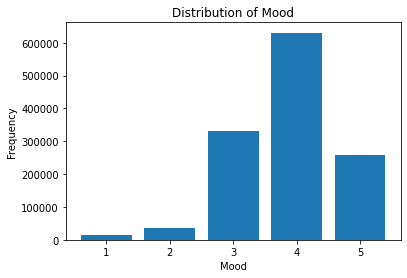

In [ ]:
# Distribution of outcome variable mood:
mood_counts = merged_df["mood"].value_counts()

plt.bar(mood_counts.index, mood_counts.values)
plt.xlabel("Mood")
plt.ylabel("Frequency")
plt.title("Distribution of Mood")
plt.show()


### 4.1 Mood Over Weekday vs Weekend across 24 hrs period:

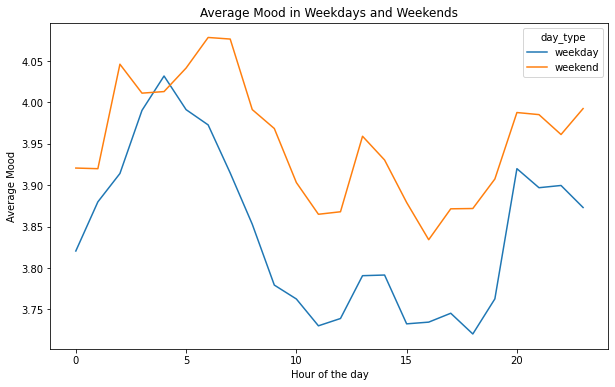

In [ ]:
# Group the data by gender and hour
grouped_mood = merged_df.groupby(['day_type', 'hour'])['mood'].mean()

# Reset the index to convert the MultiIndex to columns
grouped_mood = grouped_mood.reset_index()

# Plot the average mood over gender
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mood', hue='day_type', data=grouped_mood)
plt.xlabel('Hour of the day')
plt.ylabel('Average Mood')
plt.title('Average Mood in Weekdays and Weekends')
plt.show()


### 4.2 Based on Personality Traits over a day:

#### 4.2.1 Average mood of neurotic people over a day

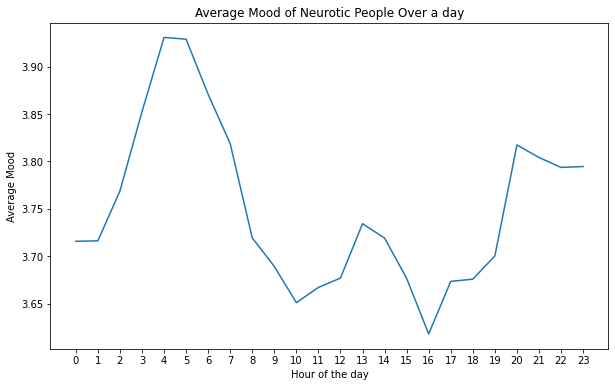

In [ ]:

# Filter data for neurotic people
neurotic_people = merged_df[merged_df['Neuroticism'] > 50]

# Group data by hour and calculate the average mood for each hour

def lineplotmood(neurotic_people, x, y):
  neurotic_people_grouped = neurotic_people.groupby(['hour'], as_index=False)['mood'].mean()

  # Plot the average mood of neurotic people over a day
  plt.figure(figsize=(10, 6))
  sns.lineplot(x='hour', y='mood', data=neurotic_people_grouped)
  plt.xlabel('Hour of the day')
  plt.ylabel('Average Mood')
  plt.title("Average Mood of " + str(x) + " Over " + str(y))
  plt.xticks(neurotic_people_grouped.index)
  plt.show()

lineplotmood(neurotic_people, "Neurotic People", "a day")

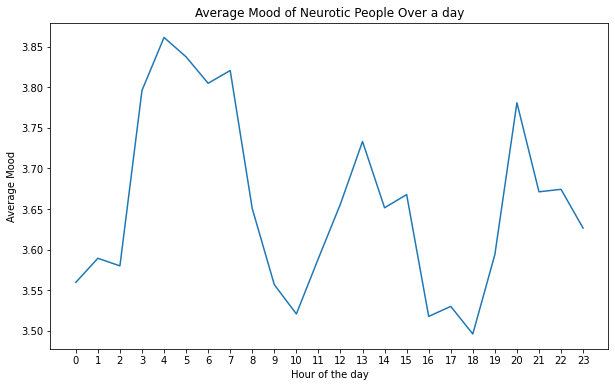

In [ ]:
neurotic_people = merged_df[merged_df['Neuroticism'] > 70]
lineplotmood(neurotic_people, "Neurotic People", "a day")

#### 4.2.2 Average mood of neurotic people over Weekdays & Weekends:

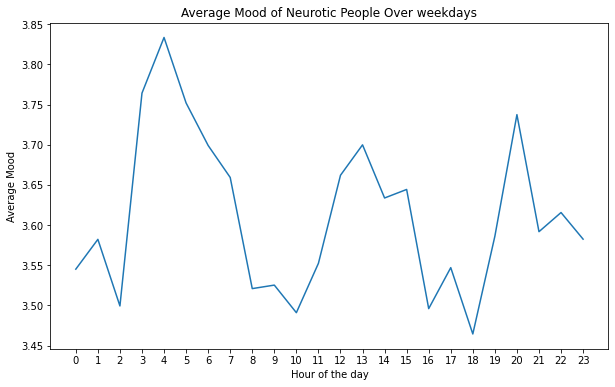

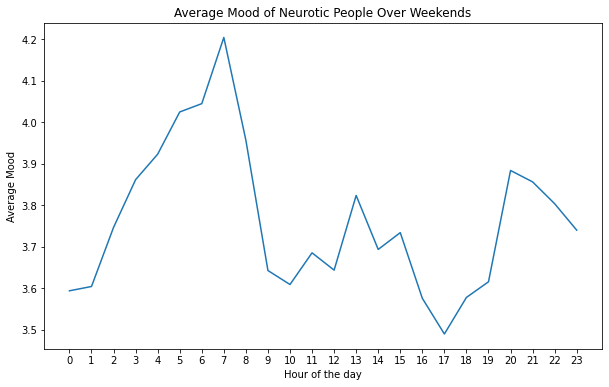

In [ ]:
# Filter data for neurotic people for weekdays

df_neurotic_weekdays = weekdays[weekdays['Neuroticism'] > 70]

lineplotmood(df_neurotic_weekdays, "Neurotic People", "weekdays")

# Filter data for neurotic people for Weekends

df_neurotic_weekends = weekends[weekends['Neuroticism'] > 70]

lineplotmood(df_neurotic_weekends, "Neurotic People", "Weekends")

#### 4.2.3 Average mood of Extrovert people over weekdays & weekends

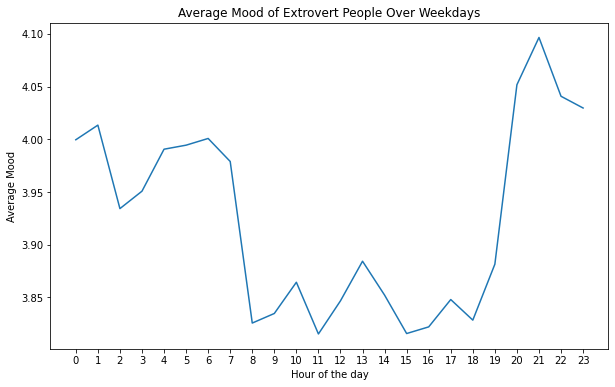

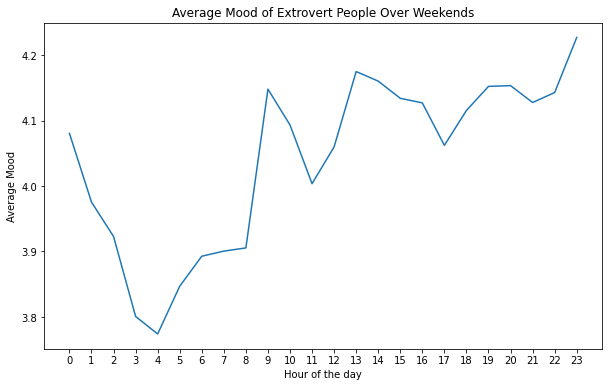

In [ ]:
df_extrovert_weekdays = weekdays[weekdays['Extraversion'] > 70]

lineplotmood(df_extrovert_weekdays, "Extrovert People", "Weekdays")

df_extrovert_weekends = weekends[weekends['Extraversion'] > 70]

lineplotmood(df_extrovert_weekends, "Extrovert People", "Weekends")

#### 4.2.4 Average mood of Conscientious people over weekdays & weekends

This is the Achievement Striving, Self-Discipline and Orderliness dimension

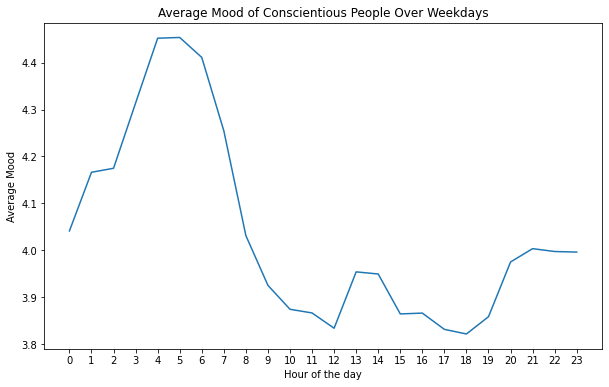

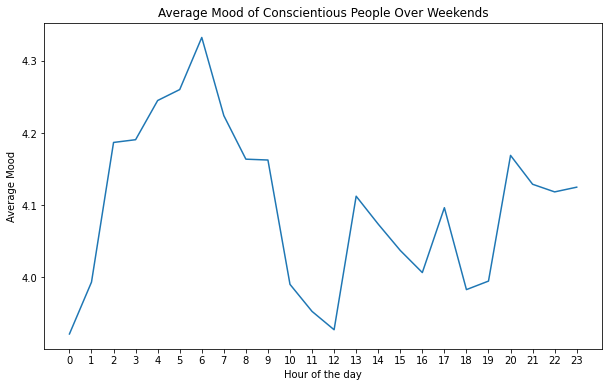

In [ ]:
df_Consc_weekdays = weekdays[weekdays['Conscientiousness'] > 70]

lineplotmood(df_Consc_weekdays, "Conscientious People", "Weekdays")

df_Consc_weekends = weekends[weekends['Conscientiousness'] > 70]

lineplotmood(df_Consc_weekends, "Conscientious People", "Weekends")

### 4.3 Based on Gender over a day

#### 4.3.1 All Days

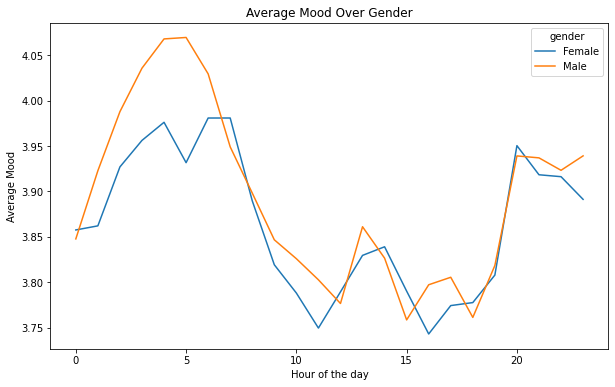

In [ ]:
# Group the data by gender and hour
grouped_gender = merged_df.groupby(['gender', 'hour'])['mood'].mean()

# Reset the index to convert the MultiIndex to columns
grouped_gender = grouped_gender.reset_index()

# Plot the average mood over gender
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mood', hue='gender', data=grouped_gender)
plt.xlabel('Hour of the day')
plt.ylabel('Average Mood')
plt.title('Average Mood Over Gender')
plt.show()


#### 4.3.2 Weekends & Weekdays

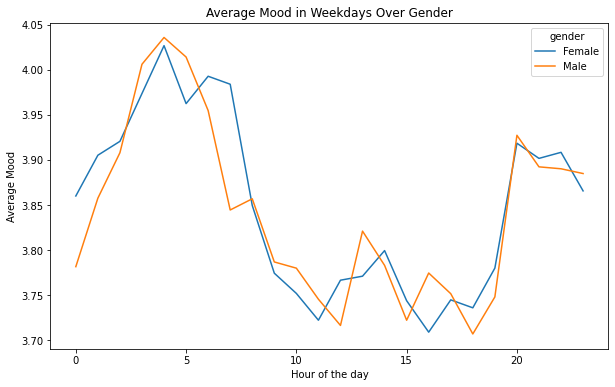

In [ ]:
# Group the data by gender and hour
grouped_gender = weekdays.groupby(['gender', 'hour'])['mood'].mean()

# Reset the index to convert the MultiIndex to columns
grouped_gender = grouped_gender.reset_index()

# Plot the average mood over gender
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mood', hue='gender', data=grouped_gender)
plt.xlabel('Hour of the day')
plt.ylabel('Average Mood')
plt.title('Average Mood in Weekdays Over Gender')
plt.show()


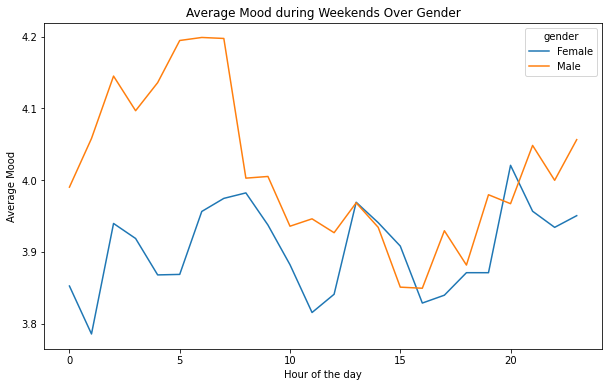

In [ ]:
# Group the data by gender and hour
grouped_gender = weekends.groupby(['gender', 'hour'])['mood'].mean()

# Reset the index to convert the MultiIndex to columns
grouped_gender = grouped_gender.reset_index()

# Plot the average mood over gender
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mood', hue='gender', data=grouped_gender)
plt.xlabel('Hour of the day')
plt.ylabel('Average Mood')
plt.title('Average Mood during Weekends Over Gender')
plt.show()


### 4.4 Based on Departments over a day

In [ ]:
merged_df[merged_df['department'] == 'Law'].head(1)

,userid,date,time,hour,what1,where,Locality,withw,city,region,...,department,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,mood,day_of_week,day_type
14664,2,2020-11-13,09:00:00,9,Lecture/seminar/conference/university meeting,Home apartment /room,Residential,Alone,Territorio Val d'Adige,Trentino-Alto Adige/Südtirol,...,Law,MSc,31.25,56.25,87.5,62.5,81.25,3,4,weekday


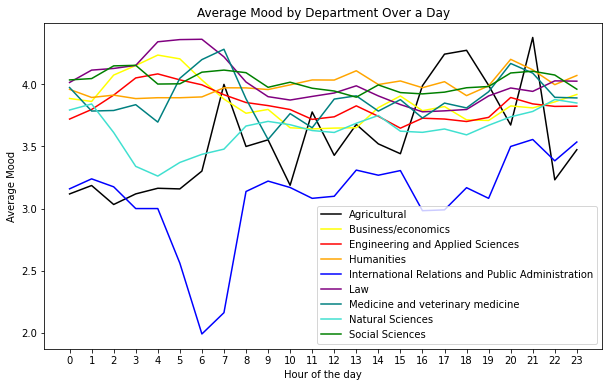

In [ ]:

def OverlayDept(merged_df,x):
  # Group data by department and hour, and calculate the average mood for each department-hour combination
  department_grouped = merged_df.groupby(['department', 'hour'])['mood'].mean()

  # Reset index to turn department and hour into separate columns
  department_grouped = department_grouped.reset_index()

  # Plot the average mood for each department over a day
  plt.figure(figsize=(10, 6))
  colors = {'Engineering and Applied Sciences': 'red', 'Law': 'purple', 'Social Sciences': 'green',
            'Natural Sciences': 'Turquoise', 'Humanities':'orange','Business/economics':'yellow', 'Medicine and veterinary medicine':'teal',
            'International Relations and Public Administration': 'blue', 'Agricultural': 'black'}
  for department, group in department_grouped.groupby('department'):
      sns.lineplot(x=group['hour'], y=group['mood'], label=department, color=colors[department])
  plt.xlabel('Hour of the day')
  plt.ylabel('Average Mood')
  plt.title(x)
  plt.xticks(department_grouped.index[0:24])
  plt.legend()
  plt.show()

OverlayDept(merged_df,'Average Mood by Department Over a Day')

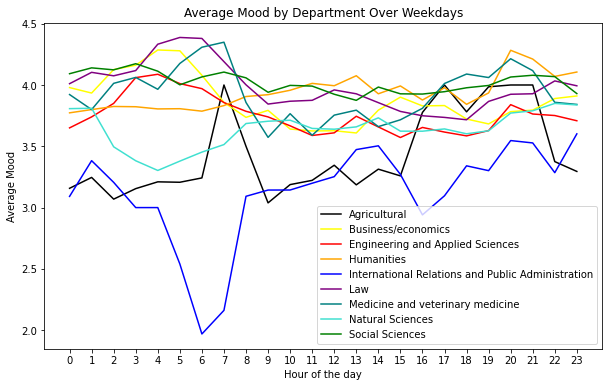

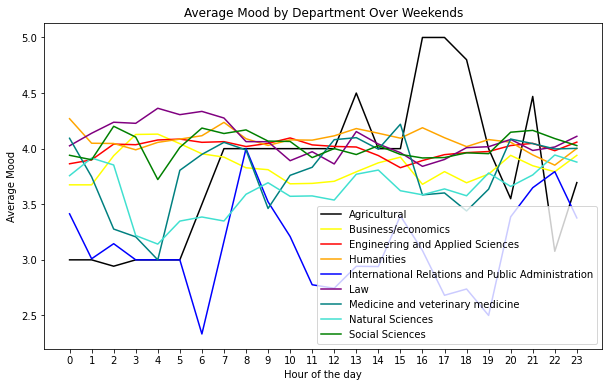

In [ ]:
OverlayDept(weekdays,'Average Mood by Department Over Weekdays')
OverlayDept(weekends,'Average Mood by Department Over Weekends')

Agri and International Relations

You can plot the relationship between mood and other variables, such as activity, location, with whom the person is, etc.

### 4.5 Mood by Activity

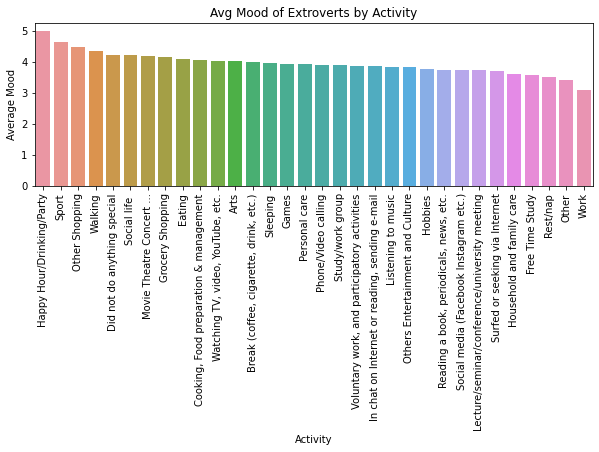

In [ ]:
def barPlotMood(df, XaxisCol,title):
  # Group data by activity and calculate the average mood for each activity
  activity_grouped = df.groupby([XaxisCol])['mood'].mean()
  activity_grouped = activity_grouped.sort_values(ascending=False)

  # Plot the average mood by activity
  plt.figure(figsize=(10, 3))
  sns.barplot(x=activity_grouped.index, y=activity_grouped.values)
  plt.xlabel('Activity')
  plt.ylabel('Average Mood')
  plt.title(title)
  plt.xticks(rotation=90)
  plt.show()

barPlotMood(df_extrovert_weekdays, 'what1','Avg Mood of Extroverts by Activity')

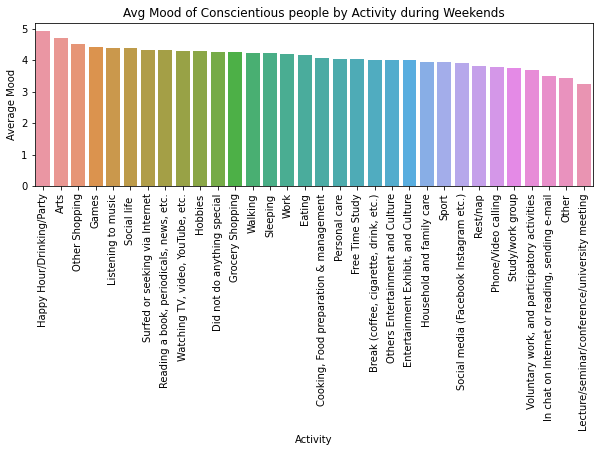

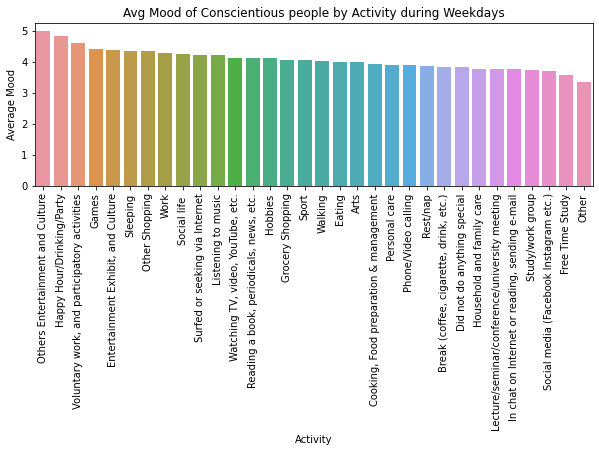

In [ ]:
barPlotMood(df_Consc_weekends, 'what1','Avg Mood of Conscientious people by Activity during Weekends')
barPlotMood(df_Consc_weekdays, 'what1','Avg Mood of Conscientious people by Activity during Weekdays')

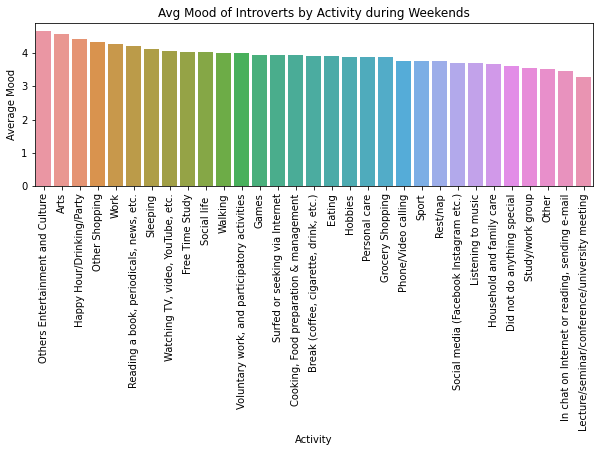

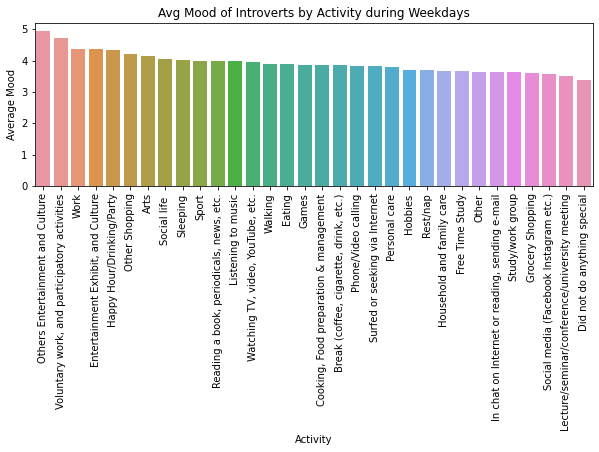

In [ ]:
df_introvert_weekdays = weekdays[weekdays['Extraversion'] < 50]
df_introvert_weekends = weekends[weekends['Extraversion'] < 50]

barPlotMood(df_introvert_weekends, 'what1','Avg Mood of Introverts by Activity during Weekends')
barPlotMood(df_introvert_weekdays, 'what1','Avg Mood of Introverts by Activity during Weekdays')

### 4.6 Mood Vs With whom:

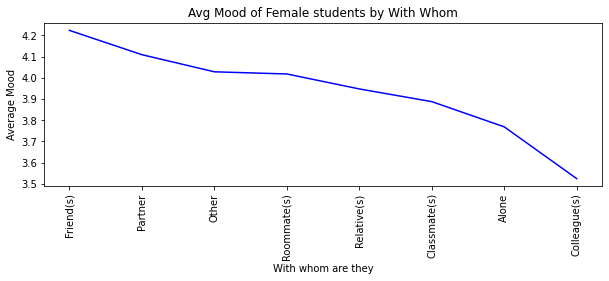

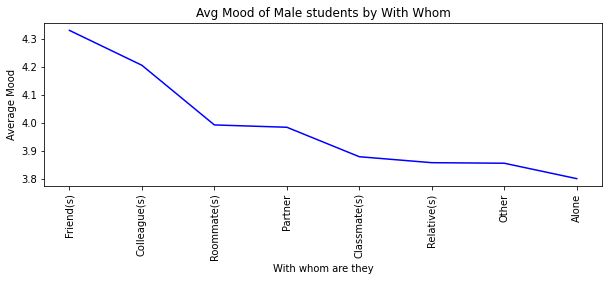

In [ ]:
def linePlotMood(df, XaxisCol,title, xlabel):
  activity_grouped = df.groupby([XaxisCol])['mood'].mean()
  activity_grouped = activity_grouped.sort_values(ascending=False)
  plt.figure(figsize=(10, 3))
  sns.lineplot(x=activity_grouped.index, y=activity_grouped.values, color = 'blue')
  plt.xlabel(xlabel)
  plt.ylabel('Average Mood')
  plt.title(title)
  plt.xticks(rotation=90)
  plt.show()

linePlotMood(merged_df[merged_df['gender'] == 'Female'], 'withw','Avg Mood of Female students by With Whom','With whom are they')
linePlotMood(merged_df[merged_df['gender'] == 'Male'], 'withw','Avg Mood of Male students by With Whom','With whom are they')


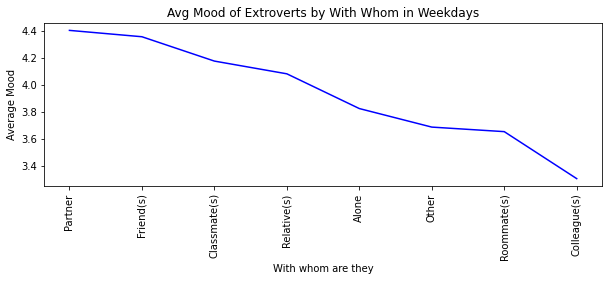

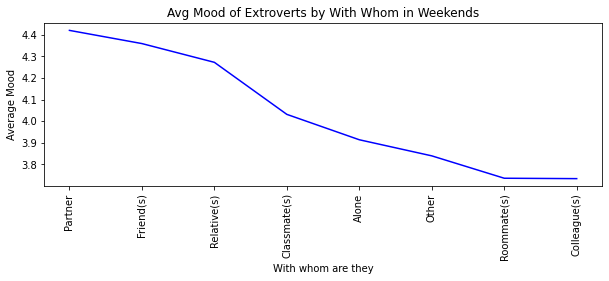

In [ ]:
linePlotMood(df_extrovert_weekdays, 'withw','Avg Mood of Extroverts by With Whom in Weekdays','With whom are they')
linePlotMood(df_extrovert_weekends, 'withw','Avg Mood of Extroverts by With Whom in Weekends','With whom are they')

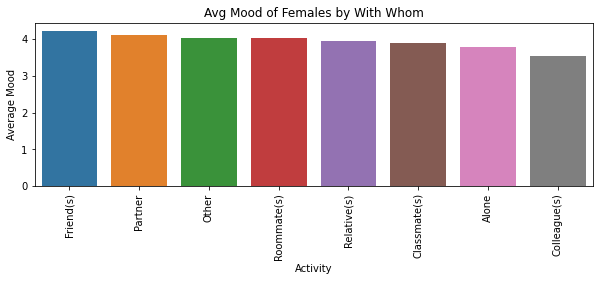

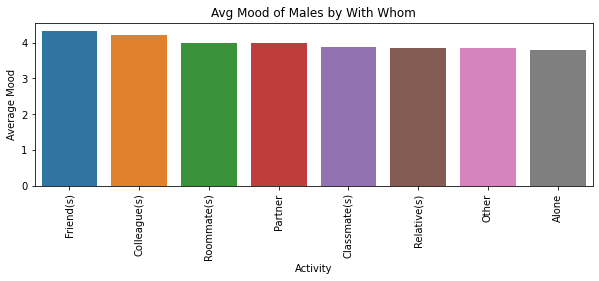

In [ ]:
barPlotMood(merged_df[merged_df['gender'] == 'Female'], 'withw','Avg Mood of Females by With Whom')
barPlotMood(merged_df[merged_df['gender'] == 'Male'], 'withw','Avg Mood of Males by With Whom')

Mood of students of all dept by with whom they are during weekdays:

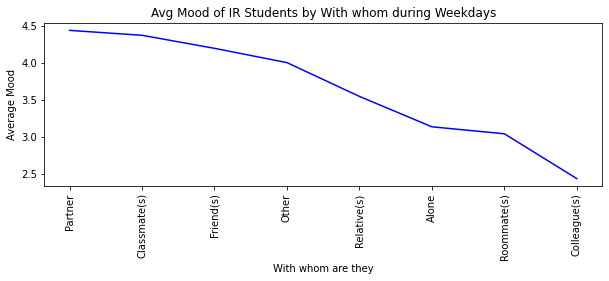

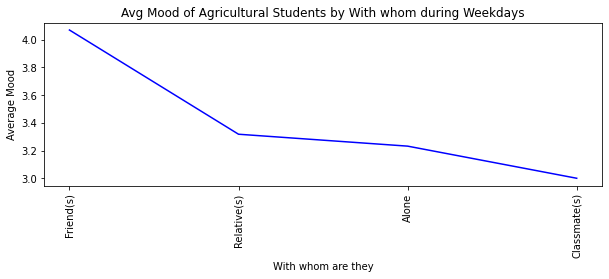

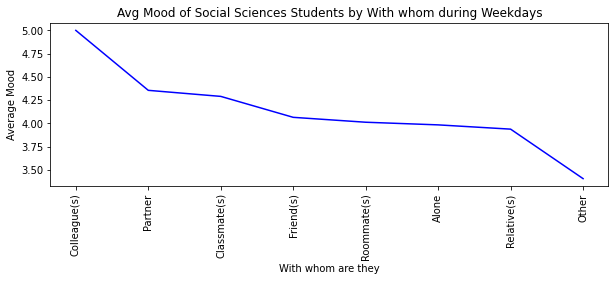

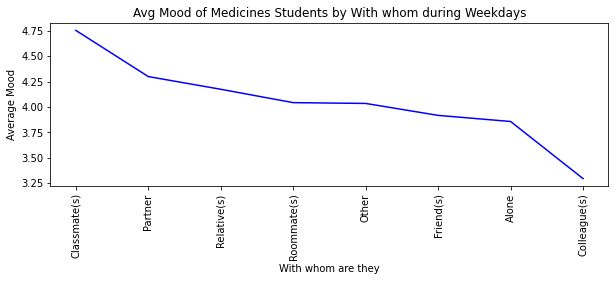

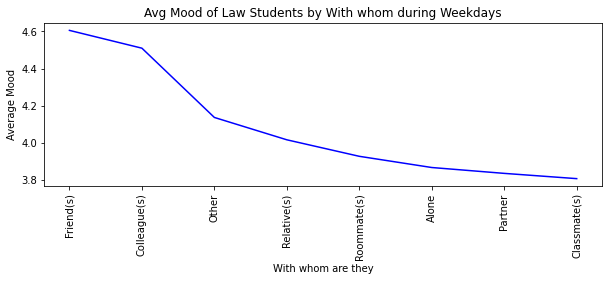

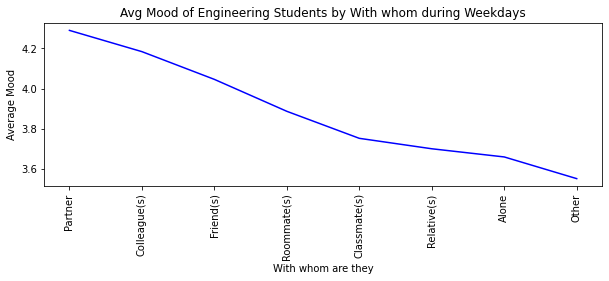

In [ ]:
linePlotMood(weekdays[weekdays['department'] == "International Relations and Public Administration"], 
             'withw', 'Avg Mood of IR Students by With whom during Weekdays','With whom are they')
linePlotMood(weekdays[weekdays['department'] == "Agricultural"], 
             'withw', 'Avg Mood of Agricultural Students by With whom during Weekdays','With whom are they')
linePlotMood(weekdays[weekdays['department'] == "Social Sciences"], 
             'withw', 'Avg Mood of Social Sciences Students by With whom during Weekdays','With whom are they')
linePlotMood(weekdays[weekdays['department'] == "Medicine and veterinary medicine"], 
             'withw', 'Avg Mood of Medicines Students by With whom during Weekdays','With whom are they')
linePlotMood(weekdays[weekdays['department'] == "Law"], 
             'withw', 'Avg Mood of Law Students by With whom during Weekdays','With whom are they')
linePlotMood(weekdays[weekdays['department'] == "Engineering and Applied Sciences"], 
             'withw', 'Avg Mood of Engineering Students by With whom during Weekdays','With whom are they')

### 4.7 Mood by Location during Weekdays and Weekends:

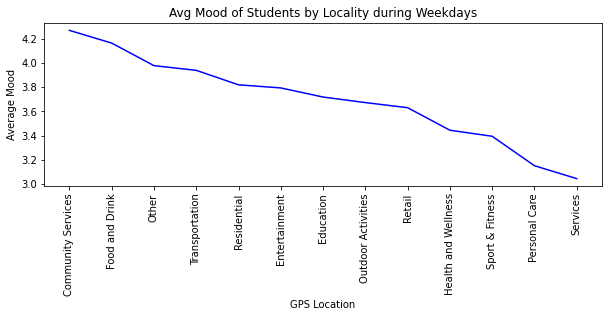

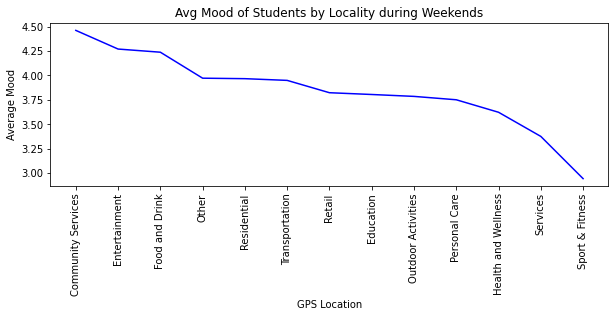

In [ ]:
linePlotMood(weekdays, 
             'Locality', 'Avg Mood of Students by Locality during Weekdays','GPS Location')
linePlotMood(weekends, 
             'Locality', 'Avg Mood of Students by Locality during Weekends','GPS Location')

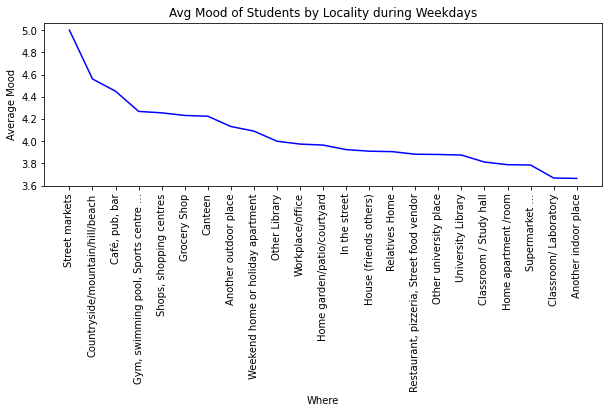

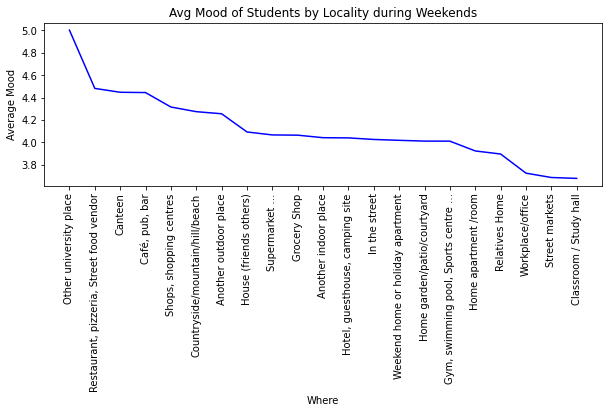

In [ ]:
linePlotMood(weekdays, 
             'where', 'Avg Mood of Students by Locality during Weekdays','Where')
linePlotMood(weekends, 
             'where', 'Avg Mood of Students by Locality during Weekends','Where')

### 4.8 box plots:

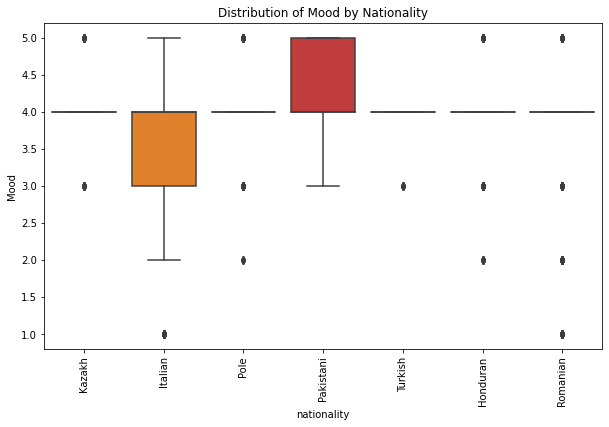

In [ ]:
def boxPlotMood(df, XaxisCol, title):
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=XaxisCol, y='mood', data=df)
  plt.xlabel(XaxisCol)
  plt.ylabel('Mood')
  plt.title(title)
  plt.xticks(rotation=90)
  plt.show()

# Plot box plots for different nationalities
boxPlotMood(merged_df, 'nationality', 'Distribution of Mood by Nationality')


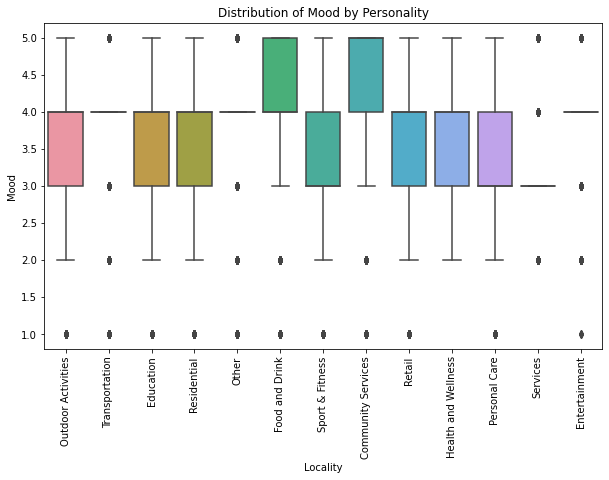

In [ ]:
boxPlotMood(merged_df, 'Locality', 'Distribution of Mood by Personality')

#5. Hypothesis testing using t - test & ANOVA test:

## 5.1 Student's t - test:

In [ ]:
# split the data into two groups based on weekday & weekend
group1 = merged_df[merged_df['day_type'] == 'weekday']['mood']
group2 = merged_df[merged_df['day_type'] == 'weekend']['mood']

# perform a t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)


# interpret the results
if p_value < 0.05:
    print('There is a significant difference in mood scores between the two day types.')
else:
    print('There is no significant difference in mood scores between the two day types.')


There is a significant difference in mood scores between the two day types.


In [ ]:
stats.ttest_ind(group1, group2)

Ttest_indResult(statistic=-76.54424553343057, pvalue=0.0)

## 5.2 ANOVA test:
For more than 2 groups.

In [ ]:
# split the data into groups based on personality
group1 = merged_df[merged_df['Extraversion'] > 70]['mood']
group2 = merged_df[merged_df['Agreeableness'] > 70]['mood']
group3 = merged_df[merged_df['Conscientiousness'] > 70]['mood']
group4 = merged_df[merged_df['Neuroticism'] > 70]['mood']
group5 = merged_df[merged_df['Openness'] > 70]['mood']

# perform ANOVA
f_statistic, p_value = stats.f_oneway(group1, group2, group3, group4, group5)

# interpret the results
if p_value < 0.05:
    print('There is a significant difference in mood scores between the different personalities.')
else:
    print('There is no significant difference in mood scores between the different personalities.')


There is a significant difference in mood scores between the different personalities.


#6. Machine Learning:

### 6.1 Split the dataset into 5 subsets.

I built 10 different models with 5 models for weekdays and 5 models for
weekends. This division I made, considering the fact that predictors which exist during
weekdays may not be present during weekends. Hence with different predictors we could
also observe different patterns of mood variations as explained in the Exploratory Analysis
segment. Within weekdays or weekends also I decided to go with 5 separate models for 5
types of personalities, one model for people high on Extraversion, one model for Neurotic
people and so on. The reason behind such separation is also similar. Since the mood variation
was quite different for different personalities, I wanted to see if the predictors play the same
role for each of these 5 cases or do they vary.

In [ ]:
weekdays = merged_df[merged_df["day_type"] == "weekday"]
weekends = merged_df[merged_df["day_type"] != "weekday"]

# Dropping 'date', 'time','city', 'nationality' columns from the weekdays and weekends datasets.

weekdays = weekdays.drop(['date', 'time','city', 'nationality'], axis=1)
weekends = weekends.drop(['date', 'time','city', 'nationality'], axis=1)

weekdays['mood'] = weekdays['mood'].astype('category')
weekends['mood'] = weekends['mood'].astype('category')

In [ ]:
df_Open_Weekdays = weekdays[weekdays['Openness']>70]
df_Open_Weekends = weekends[weekends['Openness']>70]

df_Agreeable_Weekdays = weekdays[weekdays['Agreeableness']>70]
df_Agreeable_Weekends = weekends[weekends['Agreeableness']>70]

df_neurotic_weekdays = weekdays[weekdays['Neuroticism'] > 70]
df_neurotic_weekends = weekends[weekends['Neuroticism'] > 70]

df_Consc_weekdays = weekdays[weekdays['Conscientiousness'] > 70]
df_Consc_weekends = weekends[weekends['Conscientiousness'] > 70]

df_extrovert_weekdays = weekdays[weekdays['Extraversion'] > 70]
df_extrovert_weekends = weekends[weekends['Extraversion'] > 70]

### 6.2 One-Hot Encoding the Data:

Since we have a lot of features of type categorical we have to encode them before feeding the dataset into the ML models. </br>
All the categorical features (except mood) are of nominal in nature. Hence we have to use One-Hot encoding. 

In [ ]:
df_Open_Weekdays.head(2)

,userid,hour,what1,where,Locality,withw,region,gender,department,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,mood,day_of_week,day_type
40,0,11,Study/work group,Home apartment /room,Transportation,Alone,Trentino-Alto Adige/Südtirol,Female,Engineering and Applied Sciences,MSc,68.75,87.5,93.75,50.0,87.5,3,0,weekday
41,0,11,Study/work group,Home apartment /room,Transportation,Alone,Trentino-Alto Adige/Südtirol,Female,Engineering and Applied Sciences,MSc,68.75,87.5,93.75,50.0,87.5,3,0,weekday


In [ ]:
def one_hot_encode(df, cols_to_encode):
    df = pd.get_dummies(df, columns=cols_to_encode)
    return df

In [ ]:
cols_to_encode = ['what1', 'where', 'Locality', 'withw', 'region',
       'gender', 'department', 'degree', 'day_type']

df_Open_Weekdays = one_hot_encode(df_Open_Weekdays, cols_to_encode)
df_Open_Weekends = one_hot_encode(df_Open_Weekends, cols_to_encode)
df_Agreeable_Weekdays = one_hot_encode(df_Agreeable_Weekdays, cols_to_encode)
df_Agreeable_Weekends = one_hot_encode(df_Agreeable_Weekends, cols_to_encode)
df_neurotic_weekdays = one_hot_encode(df_neurotic_weekdays, cols_to_encode)
df_neurotic_weekends = one_hot_encode(df_neurotic_weekends, cols_to_encode)
df_Consc_weekdays = one_hot_encode(df_Consc_weekdays, cols_to_encode)
df_Consc_weekends = one_hot_encode(df_Consc_weekends, cols_to_encode)
df_extrovert_weekdays = one_hot_encode(df_extrovert_weekdays, cols_to_encode)
df_extrovert_weekends = one_hot_encode(df_extrovert_weekends, cols_to_encode)

### 6.3 Gradient Boosting:

In [ ]:
def build_and_evaluate_gbm(data, target_col, test_size=0.2, random_state=42):
    # Divide the data into features (X) and target (y)
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Build the model
    model = GradientBoostingClassifier()
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test data
    test_score = model.score(X_test, y_test)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and f1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print("Test Score: ", test_score)
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    
    return model, accuracy, f1


it takes about 10 mins to execute. Hence for reference and faster execution attaching a screenshot.

![](https://drive.google.com/uc?export=view&id=1iblKIpRcYT9TOxrR8NvlVn7AePrlKOp_)

In [ ]:
# build_and_evaluate_gbm(df_Open_Weekdays, 'mood')

Test Score:  0.7803451873750109
Accuracy: 0.78
F1 Score: 0.77
Confusion Matrix: 
 [[  267    33   306   442    89]
 [   21   327   803  1598   132]
 [   39   223 19104  6331   411]
 [   36    81  3453 41968  1394]
 [    0     0   271  4547 10132]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.74      0.23      0.36      1137
           2       0.49      0.11      0.18      2881
           3       0.80      0.73      0.76     26108
           4       0.76      0.89      0.82     46932
           5       0.83      0.68      0.75     14950

    accuracy                           0.78     92008
   macro avg       0.72      0.53      0.58     92008
weighted avg       0.78      0.78      0.77     92008



(GradientBoostingClassifier(), 0.7803451873750109, 0.7687814349408137)

### 6.4 Random Forest:

Function for Random Forest Model with 5 fold Cross validation

In [ ]:

def build_and_evaluate_rf(data, target_col, test_size=0.2, random_state=42):
    # Divide the data into features (X) and target (y)
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Build the model
    model = RandomForestClassifier()
    
    # Perform 5-fold cross validation on the training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test data
    test_score = model.score(X_test, y_test)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and f1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print("Cross-Validation Scores: ", cv_scores)
    print("Mean Cross-Validation Score: ", cv_scores.mean())
    print("Test Score: ", test_score)
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    
    return model, cv_scores, accuracy, f1, X_train


#### 6.4.1 RF model for Open People on Weekdays

In [ ]:
model, cv_scores, accuracy, f1, X_train = build_and_evaluate_rf(df_Open_Weekdays, 'mood')


Cross-Validation Scores:  [0.93688015 0.93766812 0.9355759  0.9378439  0.93742273]
Mean Cross-Validation Score:  0.9370781601136482
Test Score:  0.9366250760803408
Accuracy: 0.94
F1 Score: 0.94
Confusion Matrix: 
 [[  878    43    73   100    43]
 [   42  2160   292   361    26]
 [   64   261 24108  1563   112]
 [   65   150  1025 44977   715]
 [    9    20   168   699 14054]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.77      0.80      1137
           2       0.82      0.75      0.78      2881
           3       0.94      0.92      0.93     26108
           4       0.94      0.96      0.95     46932
           5       0.94      0.94      0.94     14950

    accuracy                           0.94     92008
   macro avg       0.89      0.87      0.88     92008
weighted avg       0.94      0.94      0.94     92008



#### 6.4.2 RF model for Open People on Weekends

In [ ]:
model2, cv_scores2, accuracy2, f1_2, X_train2 = build_and_evaluate_rf(df_Open_Weekends, 'mood')

Cross-Validation Scores:  [0.94692513 0.94398167 0.94302171 0.94491066 0.94497259]
Mean Cross-Validation Score:  0.9447623514376154
Test Score:  0.9444595833230114
Accuracy: 0.94
F1 Score: 0.94
Confusion Matrix: 
 [[  276    15    18    30     3]
 [   23   670    49    91     4]
 [    2    56  8889   584    60]
 [   12    72   328 19556   444]
 [    0     2    13   436  8734]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.81      0.84       342
           2       0.82      0.80      0.81       837
           3       0.96      0.93      0.94      9591
           4       0.94      0.96      0.95     20412
           5       0.94      0.95      0.95      9185

    accuracy                           0.94     40367
   macro avg       0.91      0.89      0.90     40367
weighted avg       0.94      0.94      0.94     40367



#### 6.4.3 RF model for Agreeable People on Weekdays

In [ ]:
model3, cv_scores3, accuracy3, f1_3, X_train3 = build_and_evaluate_rf(df_Agreeable_Weekdays, 'mood')

Cross-Validation Scores:  [0.9262179  0.92568565 0.92533416 0.92669994 0.92598618]
Mean Cross-Validation Score:  0.925984767539053
Test Score:  0.9263609486470853
Accuracy: 0.93
F1 Score: 0.93
Confusion Matrix: 
 [[ 1298    65   116   119   133]
 [   55  2960   497   373    66]
 [  109   425 32731  2198   248]
 [  161   168  1586 58958  1261]
 [  184    49   279  1074 19359]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.72      0.75      0.73      1731
           2       0.81      0.75      0.78      3951
           3       0.93      0.92      0.92     35711
           4       0.94      0.95      0.94     62134
           5       0.92      0.92      0.92     20945

    accuracy                           0.93    124472
   macro avg       0.86      0.86      0.86    124472
weighted avg       0.93      0.93      0.93    124472



#### 6.4.4 RF model for Agreeable People on Weekends

In [ ]:
model4, cv_scores4, accuracy4, f1_4, X_train4 = build_and_evaluate_rf(df_Agreeable_Weekends, 'mood')

Cross-Validation Scores:  [0.93069049 0.92917397 0.92926708 0.92962252 0.9266842 ]
Mean Cross-Validation Score:  0.9290876525937234
Test Score:  0.931244313011829
Accuracy: 0.93
F1 Score: 0.93
Confusion Matrix: 
 [[  374    31    13    51    80]
 [   33   708    78    88    32]
 [   28    68 12280   723   136]
 [   22    83   728 25272   498]
 [   39    41   205   650 10491]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.75      0.68      0.72       549
           2       0.76      0.75      0.76       939
           3       0.92      0.93      0.93     13235
           4       0.94      0.95      0.95     26603
           5       0.93      0.92      0.93     11426

    accuracy                           0.93     52752
   macro avg       0.86      0.85      0.85     52752
weighted avg       0.93      0.93      0.93     52752



#### 6.4.5 RF model for Neurotic People on Weekdays

In [ ]:
model5, cv_scores5, accuracy5, f1_5, X_train5 = build_and_evaluate_rf(df_neurotic_weekdays, 'mood')

Cross-Validation Scores:  [0.90624268 0.90436753 0.91046175 0.90745371 0.90569207]
Mean Cross-Validation Score:  0.9068435478715001
Test Score:  0.9068379273704607
Accuracy: 0.91
F1 Score: 0.91
Confusion Matrix: 
 [[  734    32    31    74   109]
 [   23  1276   197    62    64]
 [   42   103 10312   526   110]
 [   74    67   489 13012   230]
 [  151    31   102   464  3683]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.72      0.75      0.73       980
           2       0.85      0.79      0.82      1622
           3       0.93      0.93      0.93     11093
           4       0.92      0.94      0.93     13872
           5       0.88      0.83      0.85      4431

    accuracy                           0.91     31998
   macro avg       0.86      0.85      0.85     31998
weighted avg       0.91      0.91      0.91     31998



#### 6.4.6 RF model for Neorotic People on Weekends

In [ ]:
model6, cv_scores6, accuracy6, f1_6, X_train6 = build_and_evaluate_rf(df_neurotic_weekends, 'mood')

Cross-Validation Scores:  [0.91276901 0.92099474 0.91582975 0.91496078 0.91936101]
Mean Cross-Validation Score:  0.9167830573274166
Test Score:  0.9136888820873823
Accuracy: 0.91
F1 Score: 0.91
Confusion Matrix: 
 [[ 198   30    6   63   75]
 [  21  259   18   17   37]
 [   8   20 3791  263    5]
 [  13   16  277 5434  120]
 [  25   10   16   88 2259]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.75      0.53      0.62       372
           2       0.77      0.74      0.75       352
           3       0.92      0.93      0.93      4087
           4       0.93      0.93      0.93      5860
           5       0.91      0.94      0.92      2398

    accuracy                           0.91     13069
   macro avg       0.85      0.81      0.83     13069
weighted avg       0.91      0.91      0.91     13069



#### 6.4.7 RF model for Conscientious People on Weekdays

In [ ]:
model7, cv_scores7, accuracy7, f1_7, X_train7 = build_and_evaluate_rf(df_Consc_weekdays, 'mood')

Cross-Validation Scores:  [0.94325268 0.94193596 0.93906476 0.94118615 0.9409667 ]
Mean Cross-Validation Score:  0.9412812494285034
Test Score:  0.9417281132958801
Accuracy: 0.94
F1 Score: 0.94
Confusion Matrix: 
 [[  337    30    20    49    58]
 [   11  1699   270    83    49]
 [   26   164 13657   990   205]
 [   16    46   707 30633   531]
 [   11    34   127   556 18043]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.84      0.68      0.75       494
           2       0.86      0.80      0.83      2112
           3       0.92      0.91      0.92     15042
           4       0.95      0.96      0.95     31933
           5       0.96      0.96      0.96     18771

    accuracy                           0.94     68352
   macro avg       0.91      0.86      0.88     68352
weighted avg       0.94      0.94      0.94     68352



#### 6.4.8 RF model for Conscientious People on Weekends

In [ ]:
model8, cv_scores8, accuracy8, f1_8, X_train8 = build_and_evaluate_rf(df_Consc_weekends, 'mood')

Cross-Validation Scores:  [0.93334998 0.93235147 0.93272591 0.93318356 0.93172457]
Mean Cross-Validation Score:  0.9326670970591474
Test Score:  0.9321684140455982
Accuracy: 0.93
F1 Score: 0.93
Confusion Matrix: 
 [[  204    23     2     4     1]
 [   34   338    46    34     1]
 [    7    45  5296   483   142]
 [    0    14   522 12498   298]
 [    5     0   154   223  9671]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.82      0.87      0.84       234
           2       0.80      0.75      0.77       453
           3       0.88      0.89      0.88      5973
           4       0.94      0.94      0.94     13332
           5       0.96      0.96      0.96     10053

    accuracy                           0.93     30045
   macro avg       0.88      0.88      0.88     30045
weighted avg       0.93      0.93      0.93     30045



####6.4.9 RF model for Extrovert People on Weekdays

In [ ]:
model9, cv_scores9, accuracy9, f1_9, X_train9 = build_and_evaluate_rf(df_extrovert_weekdays, 'mood')

Cross-Validation Scores:  [0.91362563 0.91244519 0.91450253 0.91430017 0.91271501]
Mean Cross-Validation Score:  0.9135177065767284
Test Score:  0.9108275099155492
Accuracy: 0.91
F1 Score: 0.91
Confusion Matrix: 
 [[  361    45    14    31     0]
 [   14   785   189   232    37]
 [   37   145  7236   561    99]
 [   22    86   354 17635   735]
 [   10     4    42   648  7741]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.81      0.80      0.81       451
           2       0.74      0.62      0.68      1257
           3       0.92      0.90      0.91      8078
           4       0.92      0.94      0.93     18832
           5       0.90      0.92      0.91      8445

    accuracy                           0.91     37063
   macro avg       0.86      0.83      0.85     37063
weighted avg       0.91      0.91      0.91     37063



#### 6.4.10 RF model for Extrovert People on Weekends

In [ ]:
model10, cv_scores10, accuracy10, f1_10, X_train10 = build_and_evaluate_rf(df_extrovert_weekends, 'mood')

Cross-Validation Scores:  [0.94075249 0.94348735 0.93786492 0.93692785 0.93757659]
Mean Cross-Validation Score:  0.939321837346116
Test Score:  0.938588398108638
Accuracy: 0.94
F1 Score: 0.94
Confusion Matrix: 
 [[  65    0    0   16    2]
 [   2  219   12   73    0]
 [   2   12 2421  146   34]
 [   0   31  135 8709  268]
 [   0    3   10  319 4863]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.94      0.78      0.86        83
           2       0.83      0.72      0.77       306
           3       0.94      0.93      0.93      2615
           4       0.94      0.95      0.95      9143
           5       0.94      0.94      0.94      5195

    accuracy                           0.94     17342
   macro avg       0.92      0.86      0.89     17342
weighted avg       0.94      0.94      0.94     17342



#7. Feature Importance:

Lets try to find feature importance of all these models. The idea is to check if predictors remain same for all the models or they vary.

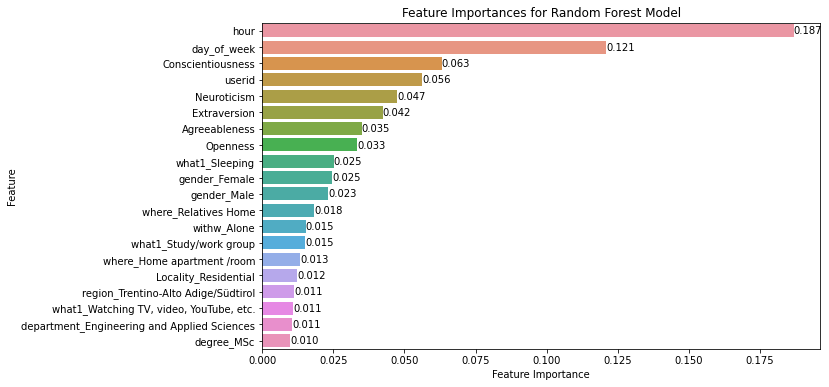

Number of features that describe majority of the prediction: 14
Features that contribute 70% towards the prediction: ['hour', 'day_of_week', 'Conscientiousness', 'userid', 'Neuroticism', 'Extraversion', 'Agreeableness', 'Openness', 'what1_Sleeping', 'gender_Female', 'gender_Male', 'where_Relatives Home', 'withw_Alone', 'what1_Study/work group']


In [ ]:
def FeatureImp(model, X_train):
  # Extract feature importances
  importances = model.feature_importances_

  # Plot the feature importances
  feature_importances = pd.DataFrame(importances, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

  # Calculate cumulative sum of feature importances
  cumulative_sum = np.cumsum(feature_importances['importance'])

  # Determine the number of features that contribute 70% towards the prediction
  num_features = np.argmax(cumulative_sum >= 0.7) + 1

  # Plot the feature importances with annotations
  plt.figure(figsize=(10,6))
  sns.barplot(x=feature_importances['importance'][0:20], y=feature_importances.index[0:20])
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importances for Random Forest Model')

  for i in range(20):
      plt.text(x = feature_importances['importance'][i], y = i, s = '{:.3f}'.format(feature_importances['importance'][i]), ha='left', va='center')

  plt.show()

  L1 = feature_importances.index[:num_features].tolist()
  print(f'Number of features that describe majority of the prediction: {num_features}')
  print(f'Features that contribute 70% towards the prediction: {feature_importances.index[:num_features].tolist()}')
  return L1

L1 = FeatureImp(model, X_train)


For X_train2:

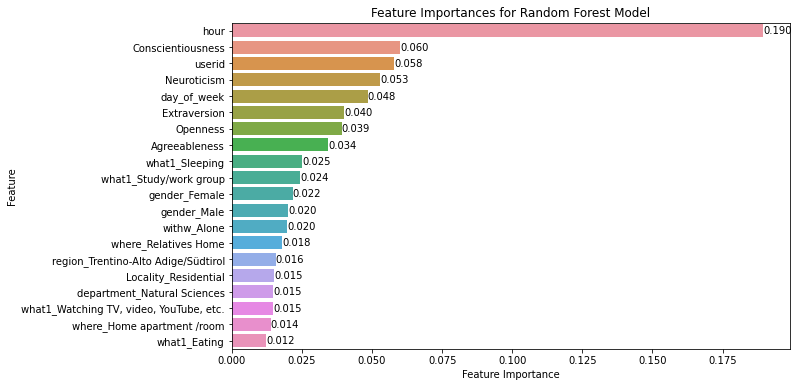

Number of features that describe majority of the prediction: 18
Features that contribute 70% towards the prediction: ['hour', 'Conscientiousness', 'userid', 'Neuroticism', 'day_of_week', 'Extraversion', 'Openness', 'Agreeableness', 'what1_Sleeping', 'what1_Study/work group', 'gender_Female', 'gender_Male', 'withw_Alone', 'where_Relatives Home', 'region_Trentino-Alto Adige/Südtirol', 'Locality_Residential', 'department_Natural Sciences', 'what1_Watching TV, video, YouTube, etc.']


In [ ]:
L2 = FeatureImp(model2, X_train2)

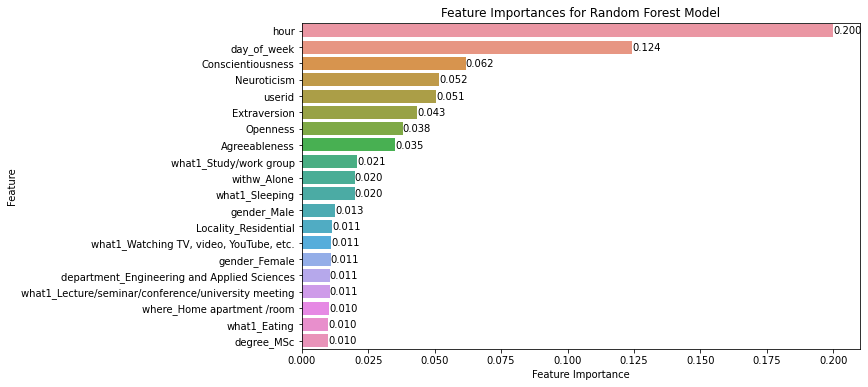

Number of features that describe majority of the prediction: 14
Features that contribute 70% towards the prediction: ['hour', 'day_of_week', 'Conscientiousness', 'Neuroticism', 'userid', 'Extraversion', 'Openness', 'Agreeableness', 'what1_Study/work group', 'withw_Alone', 'what1_Sleeping', 'gender_Male', 'Locality_Residential', 'what1_Watching TV, video, YouTube, etc.']


In [ ]:
L3 = FeatureImp(model3, X_train3)

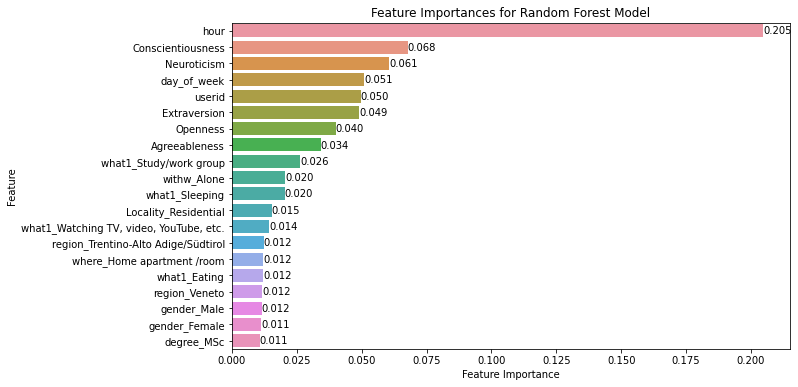

Number of features that describe majority of the prediction: 17
Features that contribute 70% towards the prediction: ['hour', 'Conscientiousness', 'Neuroticism', 'day_of_week', 'userid', 'Extraversion', 'Openness', 'Agreeableness', 'what1_Study/work group', 'withw_Alone', 'what1_Sleeping', 'Locality_Residential', 'what1_Watching TV, video, YouTube, etc.', 'region_Trentino-Alto Adige/Südtirol', 'where_Home apartment /room', 'what1_Eating', 'region_Veneto']


In [ ]:
L4 = FeatureImp(model4, X_train4)

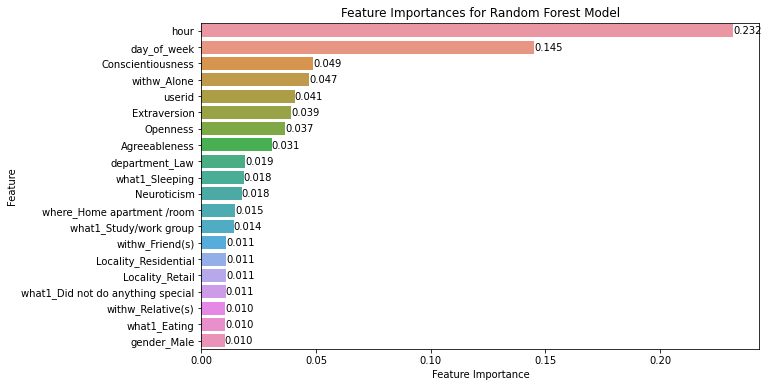

Number of features that describe majority of the prediction: 13
Features that contribute 70% towards the prediction: ['hour', 'day_of_week', 'Conscientiousness', 'withw_Alone', 'userid', 'Extraversion', 'Openness', 'Agreeableness', 'department_Law', 'what1_Sleeping', 'Neuroticism', 'where_Home apartment /room', 'what1_Study/work group']


In [ ]:
L5 = FeatureImp(model5, X_train5)

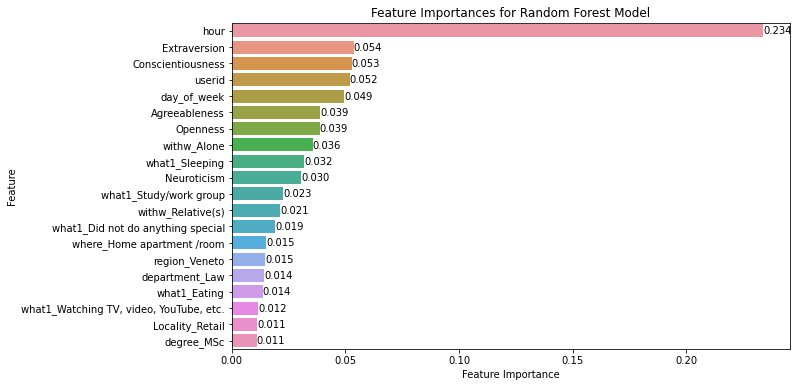

Number of features that describe majority of the prediction: 15
Features that contribute 70% towards the prediction: ['hour', 'Extraversion', 'Conscientiousness', 'userid', 'day_of_week', 'Agreeableness', 'Openness', 'withw_Alone', 'what1_Sleeping', 'Neuroticism', 'what1_Study/work group', 'withw_Relative(s)', 'what1_Did not do anything special', 'where_Home apartment /room', 'region_Veneto']


In [ ]:
L6 = FeatureImp(model6, X_train6)

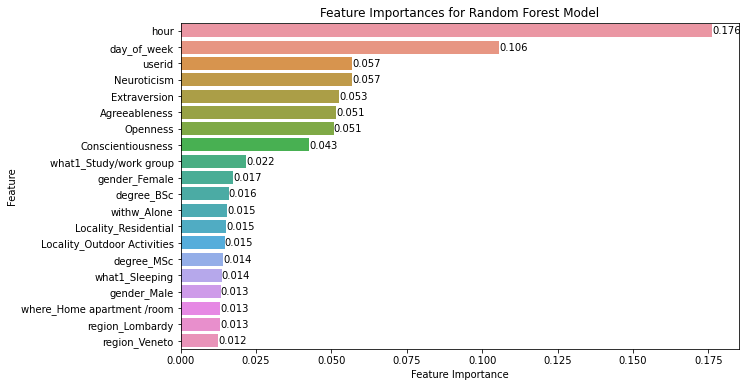

Number of features that describe majority of the prediction: 15
Features that contribute 70% towards the prediction: ['hour', 'day_of_week', 'userid', 'Neuroticism', 'Extraversion', 'Agreeableness', 'Openness', 'Conscientiousness', 'what1_Study/work group', 'gender_Female', 'degree_BSc', 'withw_Alone', 'Locality_Residential', 'Locality_Outdoor Activities', 'degree_MSc']


In [ ]:
L7 = FeatureImp(model7, X_train7)

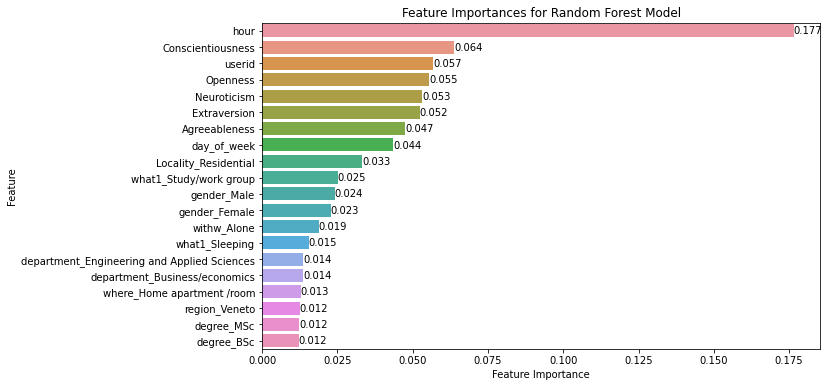

Number of features that describe majority of the prediction: 15
Features that contribute 70% towards the prediction: ['hour', 'Conscientiousness', 'userid', 'Openness', 'Neuroticism', 'Extraversion', 'Agreeableness', 'day_of_week', 'Locality_Residential', 'what1_Study/work group', 'gender_Male', 'gender_Female', 'withw_Alone', 'what1_Sleeping', 'department_Engineering and Applied Sciences']


In [ ]:
L8 = FeatureImp(model8, X_train8)

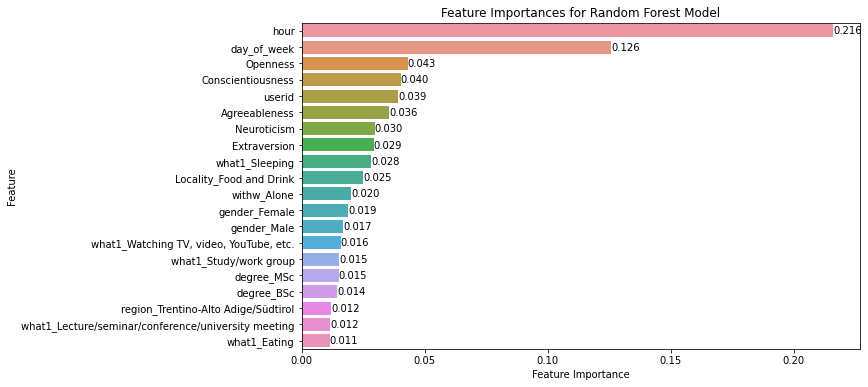

Number of features that describe majority of the prediction: 16
Features that contribute 70% towards the prediction: ['hour', 'day_of_week', 'Openness', 'Conscientiousness', 'userid', 'Agreeableness', 'Neuroticism', 'Extraversion', 'what1_Sleeping', 'Locality_Food and Drink', 'withw_Alone', 'gender_Female', 'gender_Male', 'what1_Watching TV, video, YouTube, etc.', 'what1_Study/work group', 'degree_MSc']


In [ ]:
L9 = FeatureImp(model9, X_train9)

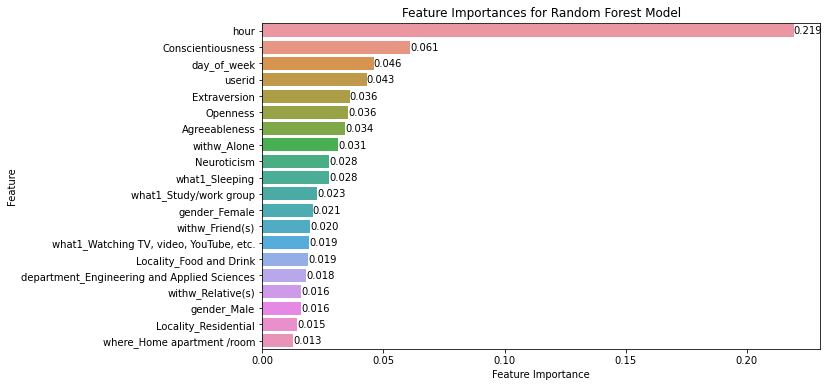

Number of features that describe majority of the prediction: 18
Features that contribute 70% towards the prediction: ['hour', 'Conscientiousness', 'day_of_week', 'userid', 'Extraversion', 'Openness', 'Agreeableness', 'withw_Alone', 'Neuroticism', 'what1_Sleeping', 'what1_Study/work group', 'gender_Female', 'withw_Friend(s)', 'what1_Watching TV, video, YouTube, etc.', 'Locality_Food and Drink', 'department_Engineering and Applied Sciences', 'withw_Relative(s)', 'gender_Male']


In [ ]:
L10 = FeatureImp(model10, X_train10)

In [ ]:
lists = [L1, L2, L3, L4, L5,L6,L7,L8,L9,L10]

for i in range(len(lists)):
    for j in range(i+1, len(lists)):
        common = set(lists[i]) & set(lists[j])
        different = set(lists[i]) - set(lists[j])
        # print(f"Common elements between list {i+1} and list {j+1}: {common}")
        print(f"Elements in list {i+1} but not in list {j+1}: {different}\n")


Elements in list 1 but not in list 2: set()

Elements in list 1 but not in list 3: {'where_Relatives Home', 'gender_Female'}

Elements in list 1 but not in list 4: {'gender_Male', 'where_Relatives Home', 'gender_Female'}

Elements in list 1 but not in list 5: {'gender_Male', 'where_Relatives Home', 'gender_Female'}

Elements in list 1 but not in list 6: {'gender_Male', 'where_Relatives Home', 'gender_Female'}

Elements in list 1 but not in list 7: {'gender_Male', 'what1_Sleeping', 'where_Relatives Home'}

Elements in list 1 but not in list 8: {'where_Relatives Home'}

Elements in list 1 but not in list 9: {'where_Relatives Home'}

Elements in list 1 but not in list 10: {'where_Relatives Home'}

Elements in list 2 but not in list 3: {'region_Trentino-Alto Adige/Südtirol', 'department_Natural Sciences', 'where_Relatives Home', 'gender_Female'}

Elements in list 2 but not in list 4: {'gender_Male', 'department_Natural Sciences', 'where_Relatives Home', 'gender_Female'}

Elements in list 2

# 8. Conclusion


The project aimed to understand the relationship between mood and various predictors in
the students of University of Trento. Through Exploratory Data Analysis, several insights
were gained on the impact of the environment on mood. For example one insight was that,
the law students exhibit relatively lower levels of happiness when they are with their
partners. Time of the day, specified as hour, day of the week and level of conscientiousness
were found to be some of the most important factors across all groups of students.
Additionally the day type was also found to play a significant role in the variation of mood,
with distinction made between weekdays and weekends. These findings highlight the
importance of considering personality traits as well as contexts in which students experience
their mood and provide valuable insights for future research in this area. Use of sensor data
has been instrumental in this research as such data have the least chances of error as
compared to self reported data. Ultimately, this work has the potential to inform educational
policies and strategies aimed at promoting the well-being of university students.